# Library import

In [17]:
import pandas as pd
import numpy as np

import bs4 as bs
import pickle
import requests
import time
import lxml
from datetime import datetime, timedelta

import yfinance as yf
import stockstats

import unicodedata
import json
from textblob import TextBlob

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest,VotingClassifier
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.tree import export_graphviz, DecisionTreeClassifier, tree
import graphviz 
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report, accuracy_score

In [18]:
target = "MSFT"

# Read Data

In [19]:
stock_without_absolute = pd.read_pickle('./data/'+target+'/stock_without_absolute.pkl')
stock_with_absolute = pd.read_pickle('./data/'+target+'/stock_with_absolute.pkl')

label_abs_1d = pd.read_pickle('./data/'+target+'/label_abs_1d.pkl')
label_abs_7d = pd.read_pickle('./data/'+target+'/label_abs_7d.pkl')
label_abs_30d = pd.read_pickle('./data/'+target+'/label_abs_30d.pkl')

label_value_1d = pd.read_pickle('./data/'+target+'/label_value_1d.pkl')
label_value_7d = pd.read_pickle('./data/'+target+'/label_value_7d.pkl')
label_value_30d = pd.read_pickle('./data/'+target+'/label_value_30d.pkl')


In [20]:
# stock_without_absolute.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

# Result Evaluation

In [21]:
def create_grid_model(classifier, param_grid):
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1)
    grid_model = GridSearchCV(classifier, param_grid=param_grid, cv=cv, n_jobs=-1,verbose=1, scoring='accuracy')
    return grid_model

In [22]:
def result(grid_model, train_data, predicted_test, test_label, predicted_train, train_label, file_name, decision_function, clf_name="Classifier"):
    print("Results for ", clf_name, ": ")
    print()
    print("The best parameters are %s" % (grid_model.best_params_))
    acc_train = accuracy_score(train_label, predicted_train)
    acc_test = accuracy_score(test_label, predicted_test)
    print("The Train Accuracy  %0.3f" % (acc_train))
    print("The Validation Accuracy   %0.3f" % (grid_model.best_score_))
    print("The Test Accuracy   %0.3f" % (acc_test ))
    
    if (clf_name[:6] == 'Random') | (clf_name == 'DecisionTree'):
        test_label_roc = np.zeros((len(test_label),2) )
        for i,v in enumerate(test_label):
            if v > 0.5:
                test_label_roc[i,1] = 1
            else:
                test_label_roc[i,0] = 1
    
    
    if (clf_name[:6] == 'Random') | (clf_name == 'DecisionTree'):
        print("AUC ROC : %0.3f" %( roc_auc_score(test_label_roc, decision_function) ))
    else:
        print("AUC ROC : %0.3f" %( roc_auc_score(test_label, decision_function) ))

    print("The mean training time of %f" % (np.mean(grid_model.cv_results_['mean_fit_time'], axis=0)) )
    print("The mean test time of %f" % (np.mean(grid_model.cv_results_['mean_score_time'], axis=0)) )
    # confusion matrix
    print("confusion matrix / precision recall scores")
    print ( confusion_matrix(test_label, predicted_test) )
    print ( classification_report(test_label, predicted_test) )
    rfc_model.best_estimator_.feature_importances_
    
    #feature importance
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(train_data.columns, grid_model.best_estimator_.feature_importances_):
        feats[feature] = importance #add the name/value pair 
    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    importances = importances.sort_values(by='Gini-importance', ascending=False)
    print(importances.head(7)) # print the top 7 features with greater importance
    
    f = open(file_name+'.txt','w')
    f.write("The best parameters are %s\n"% (grid_model.best_params_))
    f.write("The Train Accuracy %0.3f\n" % (acc_train))
    if (clf_name[:6] == 'Random') | (clf_name == 'DecisionTree'):
        f.write("AUC ROC : %0.3f\n" %( roc_auc_score(test_label_roc, decision_function) ))
    else:
        f.write("AUC ROC : %0.3f\n" %( roc_auc_score(test_label, decision_function) ))

    f.write("The Validation Accuracy %0.3f\n" % (grid_model.best_score_))
    f.write("The Test Accuracy %0.3f\n" % (acc_test ))
    f.write( str(confusion_matrix(test_label, predicted_test)) + "\n")
    f.write( str(classification_report(test_label, predicted_test)) + "\n\n")
    f.write(json.dumps(feats))
    f.close()
    
    importances.to_csv(file_name+'.csv')
    
    pass

In [23]:
best_1d_model_param = None
best_7d_model_param = None
best_30d_model_param = None

# DecisionTree Classifier

In [24]:
# 改這些地方： train_data, label, filename, clfname

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    5.3s finished


Results for  DecisionTree : 

The best parameters are {'max_depth': 1, 'max_features': 2, 'min_samples_split': 30}
The Train Accuracy  0.536
The Validation Accuracy   0.544
The Test Accuracy   0.566
AUC ROC : 0.507
The mean training time of 0.059408
The mean test time of 0.000655
confusion matrix / precision recall scores
[[132  10]
 [ 98   9]]
              precision    recall  f1-score   support

           0       0.57      0.93      0.71       142
           1       0.47      0.08      0.14       107

    accuracy                           0.57       249
   macro avg       0.52      0.51      0.43       249
weighted avg       0.53      0.57      0.47       249

                      Gini-importance
gold_change                       1.0
change                            0.0
gold_open_close_diff              0.0
y10bond_high                      0.0
y10bond_open                      0.0
gold_close_-6_r                   0.0
gold_close_-2_r                   0.0


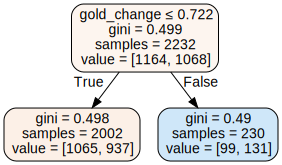

In [27]:
# stock_with_absolute, predict 1 day trend 
rfc = DecisionTreeClassifier() # classifier
max_depth = range(1,20,2)
max_features = [2 ,'sqrt', None]
min_samples_split = range(10,50,10)

# param to grid search
param_grid = dict(max_depth=max_depth, max_features=max_features, min_samples_split=min_samples_split)

# train data and label
train_data = stock_with_absolute
label = label_abs_1d

X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.1, shuffle=True)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rfc_model = create_grid_model(rfc, param_grid)
rfc_model.fit(X_train, y_train)

predicted_test = rfc_model.predict(X_test)
predicted_train = rfc_model.predict(X_train)
decision_function = rfc_model.predict_proba(X_test)

result(rfc_model, train_data, predicted_test, y_test, predicted_train, y_train, 
       "./results/"+target+"/decision_with_ABS_pred_1_d", decision_function, clf_name="DecisionTree")

best_1d_model_param = rfc_model.best_params_



dot_data = tree.export_graphviz(rfc_model.best_estimator_, 
        out_file=None, 
        feature_names=train_data.columns, # the feature names.
        filled=True, # Whether to fill in the boxes with colours.
        rounded=True, # Whether to round the corners of the boxes.
        special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('tree')
graph

In [10]:
# # stock_without_absolute, predict 1 day trend 
# rfc = DecisionTreeClassifier() # classifier
# max_depth = range(1,20,2)
# max_features = [2 ,'sqrt', None]
# min_samples_split = range(10,50,10)

# # param to grid search
# param_grid = dict(max_depth=max_depth, max_features=max_features, min_samples_split=min_samples_split)

# # train data and label
# train_data = stock_without_absolute
# label = label_abs_1d

# X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.1, random_state=42)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# rfc_model = create_grid_model(rfc, param_grid)
# rfc_model.fit(X_train, y_train)

# predicted_test = rfc_model.predict(X_test)
# predicted_train = rfc_model.predict(X_train)
# decision_function = rfc_model.predict_proba(X_test)

# result(rfc_model, train_data, predicted_test, y_test, predicted_train, y_train, 
#        "./results/decision_without_ABS_pred_1_d", decision_function, clf_name="DecisionTree")

In [11]:
# stock_with_absolute, predict 7 day trend 
rfc = DecisionTreeClassifier() # classifier
max_depth = range(1,20,2)
max_features = [2 ,'sqrt', None]
min_samples_split = range(10,50,10)

# param to grid search
param_grid = dict(max_depth=max_depth, max_features=max_features, min_samples_split=min_samples_split)

# train data and label
train_data = stock_with_absolute
label = label_abs_7d

X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.1, shuffle=True)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rfc_model = create_grid_model(rfc, param_grid)
rfc_model.fit(X_train, y_train)

predicted_test = rfc_model.predict(X_test)
predicted_train = rfc_model.predict(X_train)
decision_function = rfc_model.predict_proba(X_test)

result(rfc_model, train_data, predicted_test, y_test, predicted_train, y_train, 
       "./results/"+target+"/decision_with_ABS_pred_7_d", decision_function, clf_name="DecisionTree")

best_7d_model_param = rfc_model.best_params_

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   10.0s


Results for  DecisionTree : 

The best parameters are {'max_depth': 19, 'max_features': 'sqrt', 'min_samples_split': 10}
The Train Accuracy  0.924
The Validation Accuracy   0.650
The Test Accuracy   0.558
AUC ROC : 0.568
The mean training time of 0.163383
The mean test time of 0.002177
confusion matrix / precision recall scores
[[86 49]
 [61 53]]
              precision    recall  f1-score   support

           0       0.59      0.64      0.61       135
           1       0.52      0.46      0.49       114

    accuracy                           0.56       249
   macro avg       0.55      0.55      0.55       249
weighted avg       0.56      0.56      0.56       249

                   Gini-importance
sp500_adj close           0.045284
close                     0.038722
y10bond_open              0.037398
gold_open                 0.033454
dma                       0.030171
gold_close                0.029317
y10bond_adj close         0.025254


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   13.8s finished


In [12]:
# # stock_without_absolute, predict 7 day trend 
# rfc = DecisionTreeClassifier() # classifier
# max_depth = range(1,20,2)
# max_features = [2 ,'sqrt', None]
# min_samples_split = range(10,50,10)

# # param to grid search
# param_grid = dict(max_depth=max_depth, max_features=max_features, min_samples_split=min_samples_split)

# # train data and label
# train_data = stock_without_absolute
# label = label_abs_7d

# X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.1, random_state=42)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# rfc_model = create_grid_model(rfc, param_grid)
# rfc_model.fit(X_train, y_train)

# predicted_test = rfc_model.predict(X_test)
# predicted_train = rfc_model.predict(X_train)
# decision_function = rfc_model.predict_proba(X_test)

# result(rfc_model, train_data, predicted_test, y_test, predicted_train, y_train, 
#        "./results/decision_without_ABS_pred_7_d", decision_function, clf_name="DecisionTree")

In [13]:
# stock_with_absolute, predict 30 day trend 
rfc = DecisionTreeClassifier() # classifier
max_depth = range(1,20,2)
max_features = [2 ,'sqrt', None]
min_samples_split = range(10,50,10)

# param to grid search
param_grid = dict(max_depth=max_depth, max_features=max_features, min_samples_split=min_samples_split)

# train data and label
train_data = stock_with_absolute
label = label_abs_30d

X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.1, shuffle=True)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rfc_model = create_grid_model(rfc, param_grid)
rfc_model.fit(X_train, y_train)

predicted_test = rfc_model.predict(X_test)
predicted_train = rfc_model.predict(X_train)
decision_function = rfc_model.predict_proba(X_test)

result(rfc_model, train_data, predicted_test, y_test, predicted_train, y_train, 
       "./results/"+target+"/decision_with_ABS_pred_30_d", decision_function, clf_name="DecisionTree")

best_30d_model_param = rfc_model.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   14.6s finished


Results for  DecisionTree : 

The best parameters are {'max_depth': 7, 'max_features': None, 'min_samples_split': 10}
The Train Accuracy  0.901
The Validation Accuracy   0.838
The Test Accuracy   0.831
AUC ROC : 0.896
The mean training time of 0.183259
The mean test time of 0.001909
confusion matrix / precision recall scores
[[145  10]
 [ 32  62]]
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       155
           1       0.86      0.66      0.75        94

    accuracy                           0.83       249
   macro avg       0.84      0.80      0.81       249
weighted avg       0.84      0.83      0.83       249

              Gini-importance
open                 0.193716
y10bond_open         0.133638
macds                0.103672
gold_close           0.074474
dma                  0.057140
gold_low             0.055964
vr                   0.042186


In [14]:
# # stock_without_absolute, predict 30 day trend 
# rfc = DecisionTreeClassifier() # classifier
# max_depth = range(1,20,2)
# max_features = [2 ,'sqrt', None]
# min_samples_split = range(10,50,10)

# # param to grid search
# param_grid = dict(max_depth=max_depth, max_features=max_features, min_samples_split=min_samples_split)

# # train data and label
# train_data = stock_without_absolute
# label = label_abs_30d

# X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.1, random_state=42)
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# rfc_model = create_grid_model(rfc, param_grid)
# rfc_model.fit(X_train, y_train)

# predicted_test = rfc_model.predict(X_test)
# predicted_train = rfc_model.predict(X_train)
# decision_function = rfc_model.predict_proba(X_test)

# result(rfc_model, train_data, predicted_test, y_test, predicted_train, y_train, 
#        "./results/decision_without_ABS_pred_30_d", decision_function, clf_name="DecisionTree")

In [15]:
best_30d_model_param

{'max_depth': 7, 'max_features': None, 'min_samples_split': 10}

In [16]:
best_list = [best_1d_model_param, best_7d_model_param,  best_30d_model_param]
labels = [label_abs_1d, label_abs_7d, label_abs_30d]
file_name = ["DT_1d", "DT_7d", "DT_30d"]

for index, best_parameters in enumerate(best_list):
    print(best_parameters)
    rfc = DecisionTreeClassifier(**best_parameters)

    # train data and label
    train_data = stock_with_absolute
    label = labels[index]

    X_train, X_test, y_train, y_test = train_test_split(train_data, label, test_size=0.1, shuffle=True)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    rfc.fit(X_train, y_train)

    predicted_test = rfc.predict(X_test)
    predicted_train = rfc.predict(X_train)

    acc_train = accuracy_score(y_train, predicted_train)
    acc_test = accuracy_score(y_test, predicted_test)
    print("The Train Accuracy  %0.3f" % (acc_train))
    print("The Test Accuracy   %0.3f" % (acc_test ))
    pickle.dump(rfc, open('./backend/'+target+'/DT/'+file_name[index]+'.pkl','wb'))

{'max_depth': 9, 'max_features': 2, 'min_samples_split': 20}
The Train Accuracy  0.639
The Test Accuracy   0.442
{'max_depth': 19, 'max_features': 'sqrt', 'min_samples_split': 10}
The Train Accuracy  0.946
The Test Accuracy   0.667
{'max_depth': 7, 'max_features': None, 'min_samples_split': 10}
The Train Accuracy  0.915
The Test Accuracy   0.823
